# Forward selection in R

Agenda
* Forward stepwise feature selection
* Validation set!

We can still use the ```regsubsets``` function, but give it the flag "forward".

In [2]:
library(ISLR)
library(leaps)

In [3]:
# Data preprocessing from 1_Best_Subset_Selection.ipynb
Hitters <- na.omit(Hitters)

## Fitting forward stepwise selection

We will see that every model with 1 extra feature considered, will be a superset of the model that came before it (indicated by the stars in the summary output)

Subset selection object
Call: regsubsets.formula(Salary ~ ., data = Hitters, nvmax = 19, method = "forward")
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: forward
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2 

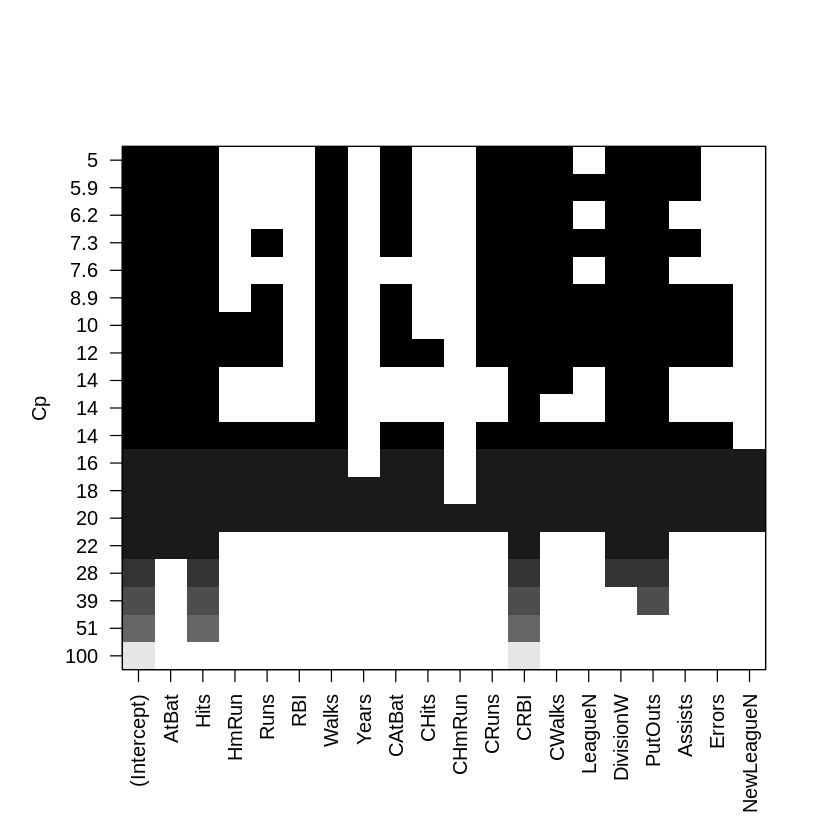

In [4]:
regfit.fwd <- regsubsets(Salary ~ ., data=Hitters, nvmax=19, method = 'forward')
summary(regfit.fwd)
plot(regfit.fwd, scale='Cp')

# Using a validation set

We can finally use a validation set to select our best model rather than use some training adjustment metric! We are simply going to pick a subset of our observations to be training, and the rest to be set aside as validation. This is **not** cross-validation! Trevor (the professor) recommends 2/3 training 1/3 validation. First thing we will do is split up our data into training and val, then simply fit our model on our 2/3 training set.

In [53]:
# There seems to be quite a bit of variability depending on the seed!
dim(Hitters)
set.seed(7)
train = sample(seq(263), 180, replace=F)
train

[1] 263  20

[1] 103 194 218 118 168  22  59  90  12 179 148  40 242  31 207 134 144 150
 [19] 187  21 132 139 102  26 215 130 100 166 171 200 124 209 123 206  36   3
 [37] 109 181  88  41 226 258   8 173 224 250  34  32 140 149  72 186 225  74
 [55] 174 122 257 114  87 133 216 236 195 117  62  55 213  28  16 178  18 252
 [73]  93 202  10 227  64 167 121 185  56 222 172   6  43  77 108 233 193  17
 [91]  33  44 203  48 162  58 113 221   9  86 116  78 254 211 163  61 196  54
[109] 104 153 175 154 188 214 205 159  82 190  81 112  79 161  75 256  76  94
[127] 125 129 237 263  95  39 208  68 131 223  14 259 158 126 142 105 197  65
[145] 231 189 147 177  35 160  96 143  37  50  23  60  66 120  11  71   2 244
[163]   1  70 127  92 192 247 235 248 212 141 157 156   4  25 115 217 110  57

In [54]:
regfit.fwd = regsubsets(Salary~., data=Hitters[train,], nvmax=19, method='forward')

We will use a custom built validation fitter in a loop! Now he uses some very strange function here ```model.matrix```. I don't understand what this does internally! But lets go ahead and plot everything out, and even include a nice legend. By plotting both the RSS and the validation, we can see the difference between judging models by training vs validation

In [55]:
val.errors=rep(NA,19)
x.test=model.matrix(Salary~.,data=Hitters[-train,]) # I think this is just a fancy way of expanding out columns into dummies if needed and removing the response.
for(i in 1:19){
    coefi <- coef(regfit.fwd,id=i) # Take out coefficients of the model
    pred=x.test[,names(coefi)]%*%coefi # No predict method, so we must do it our selves! This creates a single vector with all the predicted "response" variables based on the coefs
    val.errors[i]=mean((Hitters$Salary[-train]-pred)^2) # This computes the MSE by doing mean((actual - predicted)^2)
}

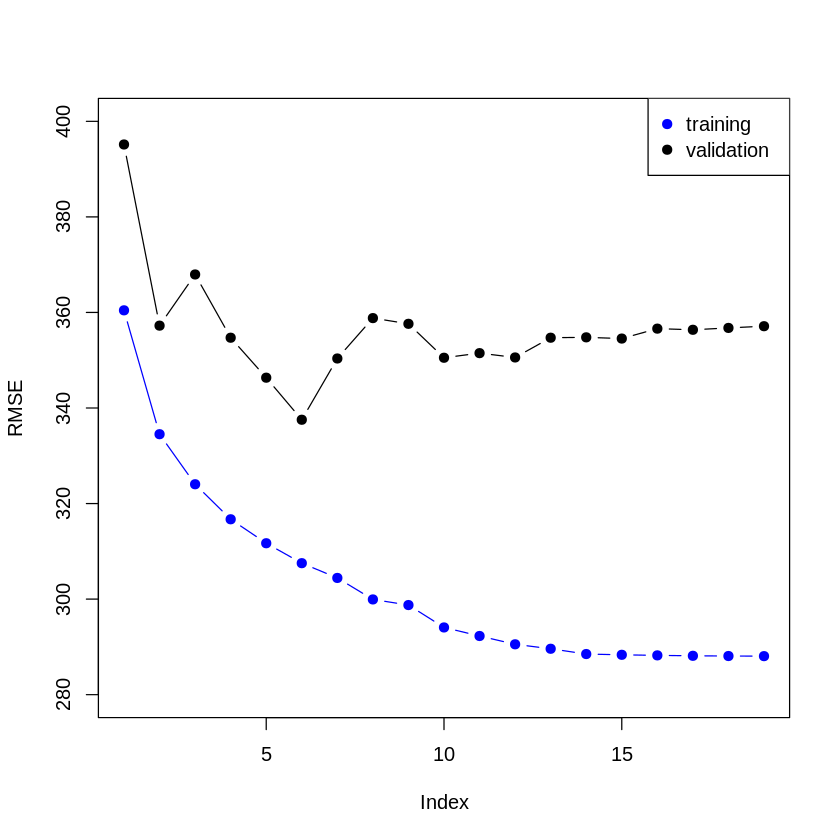

In [63]:
plot(sqrt(val.errors), ylab = 'RMSE', pch=19, type='b', ylim=c(280,400))
points(sqrt(regfit.fwd$rss[-1]/180), col='blue', pch=19, type='b')
legend("topright", legend=c("training", "validation"), col=c("blue", "black"),pch=19)

# Writing our own ```predict.regsubsets``` function

We will be doing these quite often apparently, so lets go ahead and write our own convenience function.

In [65]:
predict.regsubsets <- function(object, newdata,id, ...){
    # object is the regsubset object
    # newdata is the data to predict on
    # id is the id of the model?
    form <- as.formula(object$call[[2]]) # Regsubset has a component called call (call used to create it aka the formula)
    mat <- model.matrix(form, newdata) # Like above we make a model matrix
    coefi <- coef(object,id=id) # Extract relevant coefficients
    mat[,names(coefi)]%*%coefi # Return the predictons we make by doing a matrix multiplication
}